<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/11_student_teacher_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Student-Teacher Network for MNIST Classification

## Learning Objectives

By the end of this notebook, you will be able to:

* Train a teacher network to classify the MNIST dataset
* Understand knowledge distillation and how the student network learns from the teacher
* Implement and compare different student architectures
* Analyze the performance trade-offs between model size and accuracy

## 1. Introduction to Knowledge Distillation

Knowledge distillation is a technique where a smaller "student" model learns to mimic a larger "teacher" model. The student learns not just from the hard labels (correct classes) but also from the soft probabilities output by the teacher.

### Why Knowledge Distillation?
- **Model Compression**: Deploy smaller models on edge devices
- **Faster Inference**: Reduced computation time
- **Knowledge Transfer**: Student learns richer representations from teacher's outputs

## 2. Setup and Imports

In [21]:
# Install required packages

!pip install numpy pandas matplotlib seaborn torch tqdm scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 3. Hyperparameters

In [3]:
# Training hyperparameters
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Knowledge distillation hyperparameters
temperature = 3.0  # Temperature for softening probability distributions
alpha = 0.7       # Weight for distillation loss vs hard target loss

## 4. Dataset Preparation

MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9). Each image is 28x28 pixels.

In [4]:
# Download and prepare MNIST dataset
train_dataset = dsets.MNIST(root='./data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data/',
                           train=False,
                           transform=transforms.ToTensor())

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 35.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.77MB/s]

Training samples: 60000
Test samples: 10000


## 5. Visualize Sample Data

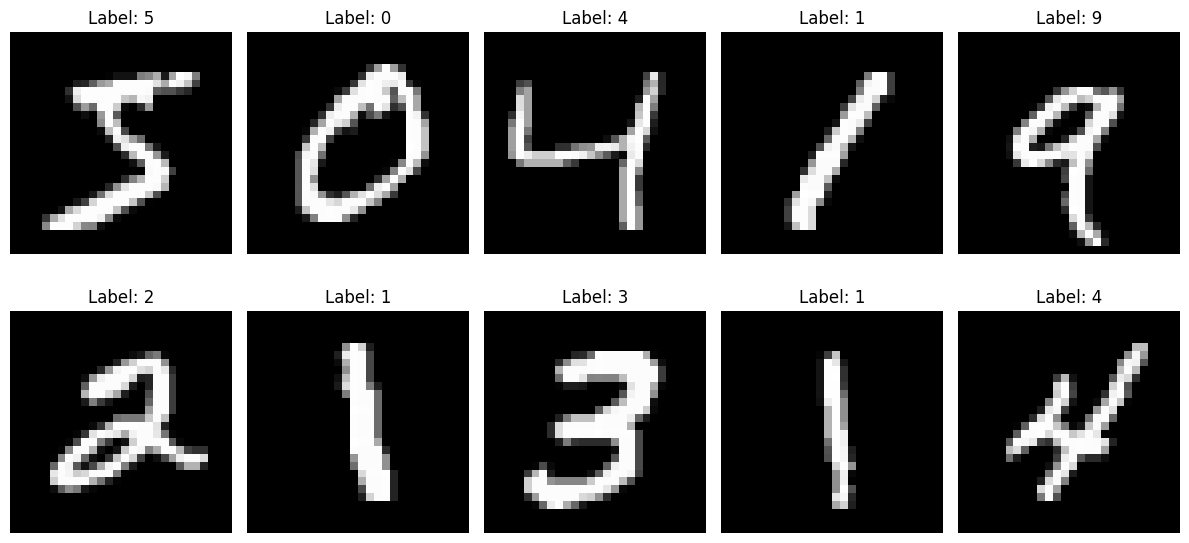

In [5]:
# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 6. Model Architectures

### Teacher Network
A larger, more complex network with multiple convolutional layers.

In [6]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 300)
        self.fc2 = nn.Linear(300, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Calculate teacher model parameters
teacher_model = Teacher()
teacher_params = sum(p.numel() for p in teacher_model.parameters())
print(f"Teacher Network Parameters: {teacher_params:,}")

Teacher Network Parameters: 481,214


### Student Network
A smaller, simpler network that will learn from the teacher.

In [7]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(14*14*16, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

# Calculate student model parameters
student_model = Student()
student_params = sum(p.numel() for p in student_model.parameters())
print(f"Student Network Parameters: {student_params:,}")
print(f"Compression Ratio: {teacher_params/student_params:.2f}x")

Student Network Parameters: 31,562
Compression Ratio: 15.25x


## 7. Training Functions

In [8]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, model_name="Model"):
    """Standard training function for any model"""
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies

def test_model(model, test_loader, model_name="Model"):
    """Test function for any model"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100. * correct / total
    print(f'{model_name} - Test Accuracy: {accuracy:.2f}%')
    return accuracy

## 8. Train Teacher Network

In [9]:
# Initialize teacher
teacher = Teacher().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(teacher.parameters(), lr=learning_rate)

# Train teacher
print("Training Teacher Network...")
teacher_losses, teacher_accs = train_model(teacher, train_loader, criterion, optimizer, num_epochs, "Teacher")

# Test teacher
teacher_accuracy = test_model(teacher, test_loader, "Teacher")

Training Teacher Network...


Epoch 1/5: 100%|██████████| 600/600 [01:24<00:00,  7.13it/s, loss=0.0244, acc=95.1]


Teacher - Epoch [1/5], Loss: 0.1553, Accuracy: 95.14%


Epoch 2/5: 100%|██████████| 600/600 [01:21<00:00,  7.32it/s, loss=0.0956, acc=98.1]


Teacher - Epoch [2/5], Loss: 0.0625, Accuracy: 98.06%


Epoch 3/5: 100%|██████████| 600/600 [01:23<00:00,  7.21it/s, loss=0.00757, acc=98.4]


Teacher - Epoch [3/5], Loss: 0.0485, Accuracy: 98.44%


Epoch 4/5: 100%|██████████| 600/600 [01:21<00:00,  7.33it/s, loss=0.0483, acc=98.7]


Teacher - Epoch [4/5], Loss: 0.0414, Accuracy: 98.69%


Epoch 5/5: 100%|██████████| 600/600 [01:21<00:00,  7.35it/s, loss=0.0191, acc=98.9]


Teacher - Epoch [5/5], Loss: 0.0364, Accuracy: 98.87%
Teacher - Test Accuracy: 99.19%


## 9. Knowledge Distillation Training

Now we'll train the student using knowledge distillation. The student learns from:
1. **Hard targets**: The true labels (standard cross-entropy loss)
2. **Soft targets**: The teacher's output probabilities (KL divergence loss)

In [10]:
def train_student_distillation(student, teacher, train_loader, num_epochs, temperature=3.0, alpha=0.7):
    """Train student using knowledge distillation"""
    student.train()
    teacher.eval()  # Teacher in evaluation mode

    # Freeze teacher parameters
    for param in teacher.parameters():
        param.requires_grad = False

    criterion_hard = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=learning_rate)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Get teacher outputs
            with torch.no_grad():
                teacher_outputs = teacher(images)

            # Get student outputs
            student_outputs = student(images)

            # Calculate losses
            # 1. Hard target loss (standard cross entropy)
            loss_hard = criterion_hard(student_outputs, labels)

            # 2. Soft target loss (KL divergence)
            T = temperature
            loss_soft = nn.KLDivLoss(reduction='batchmean')(
                F.log_softmax(student_outputs / T, dim=1),
                F.softmax(teacher_outputs / T, dim=1)
            ) * (T * T)

            # Combined loss
            loss = alpha * loss_hard + (1 - alpha) * loss_soft

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix({'loss': loss.item(), 'acc': 100.*correct/total})

        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f'Student (Distilled) - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return train_losses, train_accuracies

In [11]:
# Initialize student for distillation
student_distilled = Student().to(device)

# Train student with knowledge distillation
print("\nTraining Student Network with Knowledge Distillation...")
distilled_losses, distilled_accs = train_student_distillation(
    student_distilled, teacher, train_loader, num_epochs, temperature, alpha
)

# Test distilled student
distilled_accuracy = test_model(student_distilled, test_loader, "Student (Distilled)")


Training Student Network with Knowledge Distillation...


Epoch 1/5: 100%|██████████| 600/600 [00:53<00:00, 11.18it/s, loss=0.197, acc=93.9]


Student (Distilled) - Epoch [1/5], Loss: 0.6548, Accuracy: 93.94%


Epoch 2/5: 100%|██████████| 600/600 [00:51<00:00, 11.56it/s, loss=0.206, acc=97.7]


Student (Distilled) - Epoch [2/5], Loss: 0.2059, Accuracy: 97.72%


Epoch 3/5: 100%|██████████| 600/600 [00:52<00:00, 11.41it/s, loss=0.0848, acc=98.2]


Student (Distilled) - Epoch [3/5], Loss: 0.1648, Accuracy: 98.17%


Epoch 4/5: 100%|██████████| 600/600 [00:53<00:00, 11.23it/s, loss=0.134, acc=98.4]


Student (Distilled) - Epoch [4/5], Loss: 0.1456, Accuracy: 98.42%


Epoch 5/5: 100%|██████████| 600/600 [00:53<00:00, 11.19it/s, loss=0.115, acc=98.6]


Student (Distilled) - Epoch [5/5], Loss: 0.1325, Accuracy: 98.60%
Student (Distilled) - Test Accuracy: 97.88%


## 10. Train Student Without Distillation (Baseline)

In [12]:
# Initialize student for baseline training
student_baseline = Student().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_baseline.parameters(), lr=learning_rate)

# Train student without distillation
print("\nTraining Student Network WITHOUT Knowledge Distillation (Baseline)...")
baseline_losses, baseline_accs = train_model(
    student_baseline, train_loader, criterion, optimizer, num_epochs, "Student (Baseline)"
)

# Test baseline student
baseline_accuracy = test_model(student_baseline, test_loader, "Student (Baseline)")


Training Student Network WITHOUT Knowledge Distillation (Baseline)...


Epoch 1/5: 100%|██████████| 600/600 [00:28<00:00, 21.12it/s, loss=0.293, acc=94.3]


Student (Baseline) - Epoch [1/5], Loss: 0.1944, Accuracy: 94.30%


Epoch 2/5: 100%|██████████| 600/600 [00:28<00:00, 20.95it/s, loss=0.023, acc=97.5]


Student (Baseline) - Epoch [2/5], Loss: 0.0827, Accuracy: 97.51%


Epoch 3/5: 100%|██████████| 600/600 [00:28<00:00, 20.94it/s, loss=0.0811, acc=98.1]


Student (Baseline) - Epoch [3/5], Loss: 0.0632, Accuracy: 98.11%


Epoch 4/5: 100%|██████████| 600/600 [00:29<00:00, 20.65it/s, loss=0.0821, acc=98.3]


Student (Baseline) - Epoch [4/5], Loss: 0.0537, Accuracy: 98.33%


Epoch 5/5: 100%|██████████| 600/600 [00:28<00:00, 21.06it/s, loss=0.0186, acc=98.5]


Student (Baseline) - Epoch [5/5], Loss: 0.0475, Accuracy: 98.52%
Student (Baseline) - Test Accuracy: 98.15%


## 11. Results Comparison

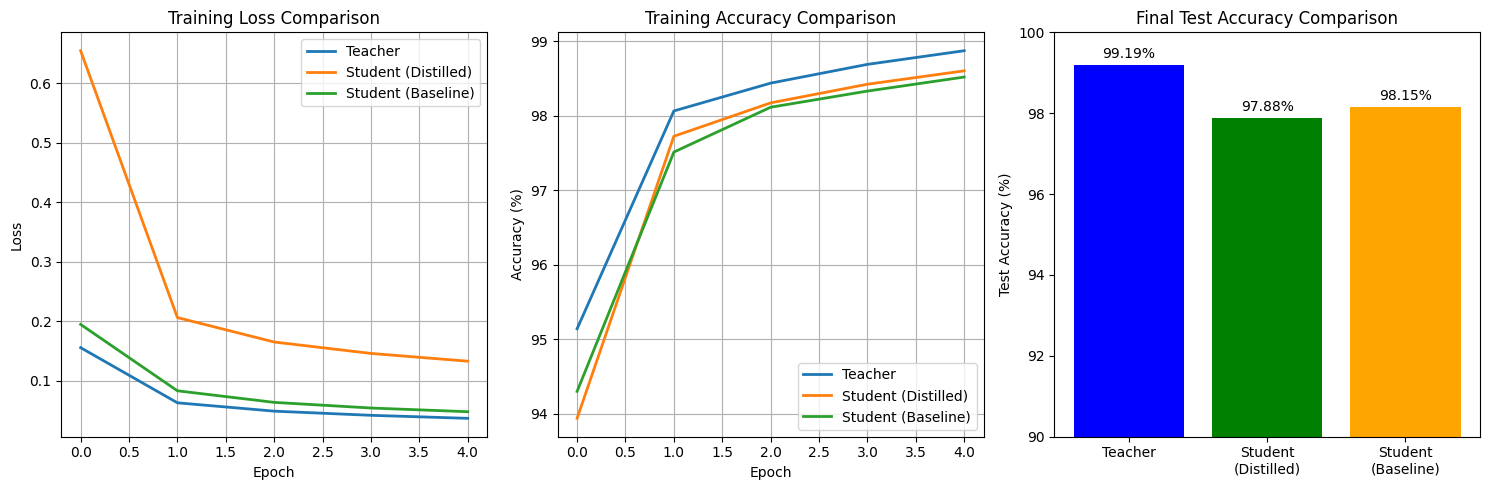


=== Summary ===
Teacher Parameters: 481,214
Student Parameters: 31,562
Compression Ratio: 15.25x

Test Accuracies:
  Teacher: 99.19%
  Student (Distilled): 97.88%
  Student (Baseline): 98.15%

Improvement from Distillation: -0.27%


In [13]:
# Plot training curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(teacher_losses, label='Teacher', linewidth=2)
plt.plot(distilled_losses, label='Student (Distilled)', linewidth=2)
plt.plot(baseline_losses, label='Student (Baseline)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(teacher_accs, label='Teacher', linewidth=2)
plt.plot(distilled_accs, label='Student (Distilled)', linewidth=2)
plt.plot(baseline_accs, label='Student (Baseline)', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True)

# Bar plot of final test accuracies
plt.subplot(1, 3, 3)
models = ['Teacher', 'Student\n(Distilled)', 'Student\n(Baseline)']
accuracies = [teacher_accuracy, distilled_accuracy, baseline_accuracy]
colors = ['blue', 'green', 'orange']
bars = plt.bar(models, accuracies, color=colors)
plt.ylabel('Test Accuracy (%)')
plt.title('Final Test Accuracy Comparison')
plt.ylim(90, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Summary ===")
print(f"Teacher Parameters: {teacher_params:,}")
print(f"Student Parameters: {student_params:,}")
print(f"Compression Ratio: {teacher_params/student_params:.2f}x")
print(f"\nTest Accuracies:")
print(f"  Teacher: {teacher_accuracy:.2f}%")
print(f"  Student (Distilled): {distilled_accuracy:.2f}%")
print(f"  Student (Baseline): {baseline_accuracy:.2f}%")
print(f"\nImprovement from Distillation: {distilled_accuracy - baseline_accuracy:.2f}%")

## 12. Visualize Model Predictions

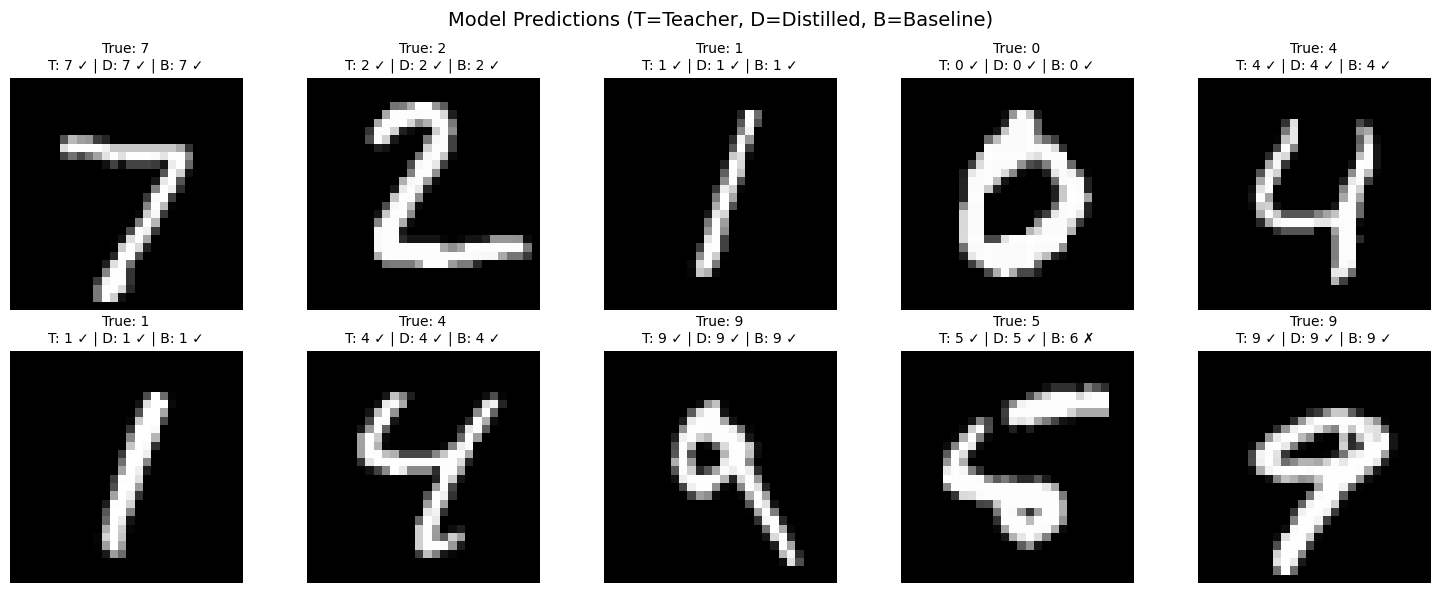

In [14]:
def visualize_predictions(teacher, student_distilled, student_baseline, test_loader, num_samples=10):
    """Visualize predictions from all three models"""
    teacher.eval()
    student_distilled.eval()
    student_baseline.eval()

    # Get a batch of test data
    images, labels = next(iter(test_loader))
    images = images[:num_samples].to(device)
    labels = labels[:num_samples]

    # Get predictions
    with torch.no_grad():
        teacher_outputs = teacher(images)
        distilled_outputs = student_distilled(images)
        baseline_outputs = student_baseline(images)

    _, teacher_preds = torch.max(teacher_outputs, 1)
    _, distilled_preds = torch.max(distilled_outputs, 1)
    _, baseline_preds = torch.max(baseline_outputs, 1)

    # Plot
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            img = images[i].cpu().squeeze()
            ax.imshow(img, cmap='gray')

            # Create title with predictions
            true_label = labels[i].item()
            t_pred = teacher_preds[i].item()
            d_pred = distilled_preds[i].item()
            b_pred = baseline_preds[i].item()

            title = f'True: {true_label}\n'
            title += f'T: {t_pred} '
            title += '✓' if t_pred == true_label else '✗'
            title += f' | D: {d_pred} '
            title += '✓' if d_pred == true_label else '✗'
            title += f' | B: {b_pred} '
            title += '✓' if b_pred == true_label else '✗'

            ax.set_title(title, fontsize=10)
            ax.axis('off')

    plt.suptitle('Model Predictions (T=Teacher, D=Distilled, B=Baseline)', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_predictions(teacher, student_distilled, student_baseline, test_loader)

---

# Challenge Section


## Challenge 1: Implement a Different Student Architecture

Design a new student architecture that:
- Has even fewer parameters than the current student
- Uses a different approach (e.g., only fully connected layers, or different conv architecture)
- Achieves at least 95% accuracy with distillation

**Hint**: You might want to experiment with:
- Different kernel sizes
- Depthwise separable convolutions
- Different activation functions

In [15]:
class TinyStudent(nn.Module):
    def __init__(self):
        super(TinyStudent, self).__init__()
        # TODO: Implement your tiny student architecture here
        # Aim for < 20,000 parameters
        pass

    def forward(self, x):
        # TODO: Implement the forward pass
        pass

# TODO: Train your TinyStudent with distillation and compare results

## Challenge 2: Temperature Analysis

Investigate how different temperature values affect the student's learning:
1. Train students with temperatures T = [1, 3, 5, 10, 20]
2. Plot the relationship between temperature and final accuracy
3. Explain your findings

In [16]:
temperatures = [1, 3, 5, 10, 20]
temperature_results = []

# TODO: For each temperature:
# 1. Create a new student model
# 2. Train it with that temperature
# 3. Test it and store the accuracy

# TODO: Create a plot showing temperature vs accuracy

## Challenge 3: Multi-Teacher Distillation

Implement a system where a student learns from multiple teachers:
1. Train 3 different teacher architectures
2. Combine their knowledge to train a single student
3. Compare with single-teacher distillation

**Hint**: You can average the soft targets from multiple teachers or use a weighted combination.

In [17]:
# TODO: Define 3 different teacher architectures
class Teacher1(nn.Module):
    # Different architecture
    pass

class Teacher2(nn.Module):
    # Different architecture
    pass

class Teacher3(nn.Module):
    # Different architecture
    pass

# TODO: Implement multi-teacher distillation training function
def train_student_multi_teacher(student, teachers, train_loader, num_epochs):
    # Your implementation here
    pass

## Challenge 4: Distillation for Other Datasets

Apply knowledge distillation to a more complex dataset:
1. Use CIFAR-10 dataset (color images, 10 classes)
2. Design appropriate teacher and student architectures
3. Compare the effectiveness of distillation on CIFAR-10 vs MNIST

**Questions to answer**:
- Is the improvement from distillation more or less pronounced on CIFAR-10?
- What architectural choices work best for color images?

In [18]:
# TODO: Load CIFAR-10 dataset
# TODO: Design teacher and student architectures for CIFAR-10
# TODO: Train and compare results

## Challenge 5: Analysis Questions

Answer the following questions based on your experiments:

1. **Why does knowledge distillation work?** Explain in your own words why learning from soft targets helps the student network.

2. **When might distillation fail?** Can you think of scenarios where knowledge distillation might not help or even hurt performance?

3. **Real-world applications**: List 3 real-world scenarios where knowledge distillation would be particularly useful.

4. **Optimal α value**: Based on your experiments, what seems to be the optimal balance between hard and soft targets? Does this depend on the dataset or architecture?

In [19]:
# Your answers here:
# 1. Why does knowledge distillation work?
# Answer:

# 2. When might distillation fail?
# Answer:

# 3. Real-world applications:
# Answer:

# 4. Optimal α value:
# Answer:

## Bonus Challenge: Implement Progressive Distillation

Implement a progressive distillation approach where:
1. Train a large teacher
2. Train a medium-sized student from the teacher
3. Train a tiny student from the medium student
4. Compare this "chain" approach with direct distillation from teacher to tiny student

In [20]:
# TODO: Implement progressive distillation
# Your code here